In [903]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

### **Load cleaned data**

In [904]:
portfolio = pd.read_pickle('../data/portfolio_cleaned.pkl')
profile = pd.read_pickle('../data/profile_cleaned.pkl')
transcript = pd.read_pickle('../data/transcript_cleaned.pkl')

### **Merge profile and transcript datasets**

I use an inner join for the transcript and profile datasets as I deleted user_ids with age 118, no gender and no income. These entries won't help us in classifying users later on in the modeling stage. Then I merge the joined dataset with the portfolio dataset to add the offer type. Finally, I drop all the rows, I won't need to define my target variable.

In [905]:
profile_transcript = pd.merge(transcript, profile, how='inner', on='user_id')
merged = pd.merge(profile_transcript, portfolio, how='left', on='offer_id')
merged.drop(['gender', 'age', 'income', 'member_days', 'amount_spent', 'reward_received', 'offer_reward', 'offer_channels', 'offer_difficulty'], axis=1, inplace=True)
merged.head(3)

,user_id,status,test_time,offer_id,offer_duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,5.50,NaN,NaN,NaN


In [906]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272762 entries, 0 to 272761
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         272762 non-null  object 
 1   status          272762 non-null  object 
 2   test_time       272762 non-null  float64
 3   offer_id        148805 non-null  object 
 4   offer_duration  148805 non-null  float64
 5   offer_type      148805 non-null  object 
dtypes: float64(2), object(4)
memory usage: 12.5+ MB


### **Examine data and create cross dataset visuals**

Let's have a look at the campaign funnel for discount, discount and informational offers from offer received until offer completed.

In [907]:
campaign_funnel = merged.groupby(['offer_type','status'])['user_id'].count()
campaign_funnel

offer_type     status         
bogo           offer completed    15258
               offer received     26537
               offer viewed       22039
discount       offer completed    17186
               offer received     26664
               offer viewed       18461
informational  offer received     13300
               offer viewed        9360
Name: user_id, dtype: int64

Text(0.5, 1.0, 'informational')

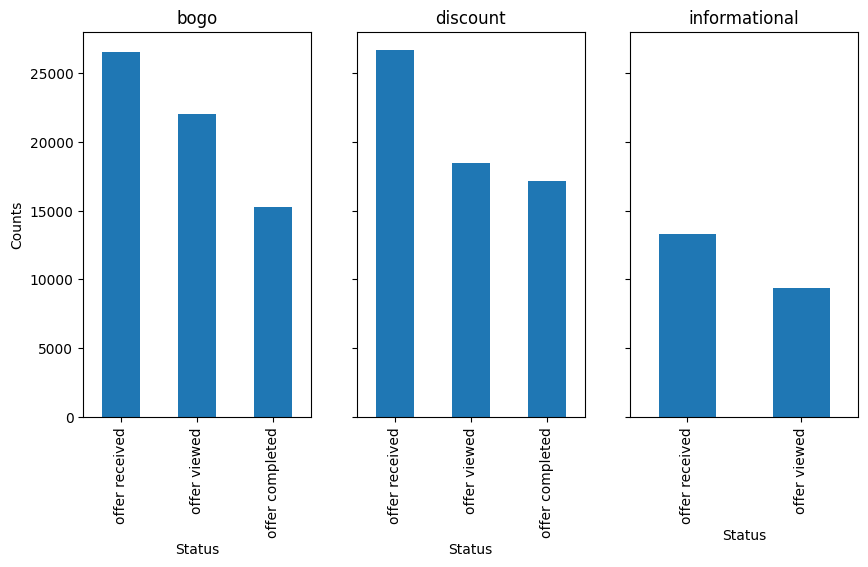

In [908]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True)

ax1 = plt.subplot(131)
discount = merged[merged['offer_type'] == 'bogo'].status.value_counts()
discount.plot(kind='bar', figsize=(10,5))
plt.ylabel('Counts')
plt.xlabel('Status')
plt.title('bogo')

ax2 = plt.subplot(132)
discount = merged[merged['offer_type'] == 'discount'].status.value_counts()
discount.plot(kind='bar' , figsize=(10,5))
plt.ylabel('Counts')
plt.xlabel('Status')
plt.title('discount')

ax3 = plt.subplot(133)
informational = merged[merged['offer_type'] == 'informational'].status.value_counts()
informational.plot(kind='bar' , figsize=(10,5))
plt.ylabel('Counts')
plt.xlabel('Status')
plt.title('informational')

Let's have a look at the view and complete rates for the different offer_types:

In [909]:
print('---bogo:---')
print('offer_view_rate:', "{:.1%}".format(campaign_funnel.iloc[2]/campaign_funnel.iloc[1]))
print('offer_complete_rate', "{:.1%}".format(campaign_funnel.iloc[0]/campaign_funnel.iloc[1]))
print('\n')
print('---discount:---')
print('offer_view_rate:', "{:.1%}".format(campaign_funnel.iloc[5]/campaign_funnel.iloc[4]))
print('offer_complete_rate', "{:.1%}".format(campaign_funnel.iloc[3]/campaign_funnel.iloc[4]))
print('\n')
print('---informationl:---')
print('offer_view_rate:', "{:.1%}".format(campaign_funnel.iloc[7]/campaign_funnel.iloc[6]))

---bogo:---
offer_view_rate: 83.1%
offer_complete_rate 57.5%


---discount:---
offer_view_rate: 69.2%
offer_complete_rate 64.5%


---informationl:---
offer_view_rate: 70.4%


### **Define Target Variable**

As the rates vary between the offer types, I decide to build three different machine learning models. For discount, discount and informational offers.  
However, the logic to build the target variables for discount and discount offers is the same.
  
So, let's define our logic whom to send an offer and to whom not:

**discount** and **discount**:  
offer received > offer viewed > transaction > offer completed -> send offer = 1  
transaction                                                   -> don't send offer = 0  
offer received > transaction                                  -> don't send offer = 0  
offer received > transaction > offer viewed                   -> don't send offer = 0  
offer received > transaction > offer completed > offer viewed -> don't send offer = 0  
offer received > offer viewed                                 -> don't send offer = 0  

**informational**:  
offer received > offer viewed > transaction                   -> send offer = 1  
transaction                                                   -> don't send offer = 0  
offer received > transaction                                  -> don't send offer = 0  
offer received > transaction > offer viewed                   -> don't send offer = 0  

Above, we basically **send** those users an **offer** who **made a transaction within the offer duration and after they viewed the offer**.  
In all other possible combinations, users make a transaction without viewing the offer. Hence, we can assume that they  
would have made a purchase either way. So, we won't send them an offer as this would result in forgone revenues.  

Let's code this logic:

1. We start by filtering the dataset by user_id and test_time.

In [910]:
merged.sort_values(by=['user_id', 'test_time'], inplace=True)
merged.head()

,user_id,status,test_time,offer_id,offer_duration,offer_type
252233,0009655768c64bdeb2e877511632db8f,offer received,7.0,5a8bc65990b245e5a138643cd4eb9837,3.0,informational
252234,0009655768c64bdeb2e877511632db8f,offer viewed,8.0,5a8bc65990b245e5a138643cd4eb9837,3.0,informational
252235,0009655768c64bdeb2e877511632db8f,transaction,9.5,NaN,NaN,NaN
252236,0009655768c64bdeb2e877511632db8f,offer received,14.0,3f207df678b143eea3cee63160fa8bed,4.0,informational
252237,0009655768c64bdeb2e877511632db8f,offer viewed,15.5,3f207df678b143eea3cee63160fa8bed,4.0,informational


2. Forward fill missing cells by user_id, so we have the offer id of the last offer in transaction rows

In [911]:
merged.update(merged.groupby(['user_id']).ffill())
merged.head()

,user_id,status,test_time,offer_id,offer_duration,offer_type
252233,0009655768c64bdeb2e877511632db8f,offer received,7.0,5a8bc65990b245e5a138643cd4eb9837,3.0,informational
252234,0009655768c64bdeb2e877511632db8f,offer viewed,8.0,5a8bc65990b245e5a138643cd4eb9837,3.0,informational
252235,0009655768c64bdeb2e877511632db8f,transaction,9.5,5a8bc65990b245e5a138643cd4eb9837,3.0,informational
252236,0009655768c64bdeb2e877511632db8f,offer received,14.0,3f207df678b143eea3cee63160fa8bed,4.0,informational
252237,0009655768c64bdeb2e877511632db8f,offer viewed,15.5,3f207df678b143eea3cee63160fa8bed,4.0,informational


3. Next, we filter only for the status offer viewed, transaction and offer completed.

In [912]:
merged_filtered = merged[(merged['status'] == 'offer viewed') |
                         (merged['status'] == 'transaction') |
                         (merged['status'] == 'offer completed')
                         ].sort_values(by=['user_id', 'test_time'])

4. Now, we create a new dataset with rows shifted by 1 and concate it together with the originial dataset. This way we can compare whether the sequence offer viewed and transaction is holding as well as the transaction took place within the offer duration. In my opinion it's secondary whether the offer is completed since offers are all about activating a customer.

In [913]:
merged_filtered['offer_id_shifted'] = merged_filtered.groupby(['user_id', 'offer_id'])['offer_id'].shift(1)
merged_filtered.head()

,user_id,status,test_time,offer_id,offer_duration,offer_type,offer_id_shifted
252234,0009655768c64bdeb2e877511632db8f,offer viewed,8.00,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,NaN
252235,0009655768c64bdeb2e877511632db8f,transaction,9.50,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
252237,0009655768c64bdeb2e877511632db8f,offer viewed,15.50,3f207df678b143eea3cee63160fa8bed,4.0,informational,NaN
252239,0009655768c64bdeb2e877511632db8f,transaction,17.25,f19421c1d4aa40978ebb69ca19b0e20d,5.0,bogo,NaN
252240,0009655768c64bdeb2e877511632db8f,offer completed,17.25,f19421c1d4aa40978ebb69ca19b0e20d,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d


Create a column completed_offer that indicates whether a user reacted to a offer viewed. Then we merge back all rows with status offer received.

In [914]:
merged_filtered['completed_offer'] = np.where(merged_filtered['offer_id_shifted'] == merged_filtered['offer_id'],1,0)

offers_received = merged[(merged['status'] == 'offer received')].copy()
offers_received['offer_id_shifted'] = np.nan
offers_received['completed_offer'] = np.nan

merged_back = pd.concat([merged_filtered, offers_received], axis=0).sort_values(by=['user_id', 'test_time'])

merged_back.head()

,user_id,status,test_time,offer_id,offer_duration,offer_type,offer_id_shifted,completed_offer
252233,0009655768c64bdeb2e877511632db8f,offer received,7.0,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,NaN,NaN
252234,0009655768c64bdeb2e877511632db8f,offer viewed,8.0,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,NaN,0.0
252235,0009655768c64bdeb2e877511632db8f,transaction,9.5,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,1.0
252236,0009655768c64bdeb2e877511632db8f,offer received,14.0,3f207df678b143eea3cee63160fa8bed,4.0,informational,NaN,NaN
252237,0009655768c64bdeb2e877511632db8f,offer viewed,15.5,3f207df678b143eea3cee63160fa8bed,4.0,informational,NaN,0.0


Next we can split the dataset by offer type and create three distinct datasets.

In [915]:
bogo = merged_back[merged_back['offer_type'] == 'bogo']
discount = merged_back[merged_back['offer_type'] == 'discount']
informational = merged_back[merged_back['offer_type'] == 'informational']

In [916]:
bogo.head(10)

,user_id,status,test_time,offer_id,offer_duration,offer_type,offer_id_shifted,completed_offer
252238,0009655768c64bdeb2e877511632db8f,offer received,17.00,f19421c1d4aa40978ebb69ca19b0e20d,5.0,bogo,NaN,NaN
252239,0009655768c64bdeb2e877511632db8f,transaction,17.25,f19421c1d4aa40978ebb69ca19b0e20d,5.0,bogo,NaN,0.0
252240,0009655768c64bdeb2e877511632db8f,offer completed,17.25,f19421c1d4aa40978ebb69ca19b0e20d,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0
252241,0009655768c64bdeb2e877511632db8f,offer viewed,19.00,f19421c1d4aa40978ebb69ca19b0e20d,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0
51192,0011e0d4e6b944f998e987f904e8c1e5,offer received,21.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,NaN,NaN
51193,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,21.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,NaN,0.0
51194,0011e0d4e6b944f998e987f904e8c1e5,transaction,24.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0
51196,0011e0d4e6b944f998e987f904e8c1e5,offer completed,24.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0
51197,0011e0d4e6b944f998e987f904e8c1e5,transaction,26.75,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0
51198,0011e0d4e6b944f998e987f904e8c1e5,transaction,27.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0


#### bogo & discount offers

First, we can easily filter out those users who reacted successfully to the offers. Let's do that for discount and discount offers.

In [917]:
bogo_completed = bogo[(bogo['completed_offer'] == 1) & (bogo['status'] == 'offer completed')][['user_id', 'offer_id']]\
                     .groupby(['user_id', 'offer_id']).count().reset_index()

discount_completed = discount[(discount['completed_offer'] == 1) & (discount['status'] == 'offer completed')][['user_id', 'offer_id']]\
                             .groupby(['user_id', 'offer_id']).count().reset_index()

Next, let's find those users who didn't purchase anything after receiving an offer:  
offer received -> not seen  
offer received > offer viewed -> not reacted

##### bogo offers

In [918]:
#subset offer ids that have transactions or conversions by person and offer_id
conversion_ids_bogo = bogo[(bogo['status'] == 'transaction') | (bogo['status'] == 'offer completed')][['user_id', 'offer_id']]\
                          .groupby(['user_id', 'offer_id']).count().reset_index()

#check for unique person-offer_id pairs that consist of offers received 
offers_received_only_bogo = bogo[['user_id', 'offer_id']][bogo['status'] == 'offer received'].groupby(['user_id', 'offer_id']).count().reset_index()

#create merged dataset to diffrentiate groups
check_merge_bogo = conversion_ids_bogo.merge(offers_received_only_bogo, how='right', on=['user_id', 'offer_id'], indicator=True)

check_merge_bogo.head()

,user_id,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,both
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,both
2,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,both
3,0020c2b971eb4e9188eac86d93036a77,ae264e3637204a6fb9bb56bc8210ddfd,right_only
4,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,both


In [919]:
# find user_id and offer_id for offers users have seen
not_seen_reacted_bogo = check_merge_bogo[check_merge_bogo['_merge'] == 'right_only']
not_seen_reacted_bogo  = not_seen_reacted_bogo.merge(merged,how='left',on=['user_id', 'offer_id'])
not_reacted_bogo = not_seen_reacted_bogo[not_seen_reacted_bogo['status'] == 'offer viewed'][['user_id', 'offer_id']]\
                                        .groupby(['user_id', 'offer_id']).count().reset_index()

# find user_id and offer_id for offers users haven't seen
not_seen_reacted_bogo.drop(['_merge'], axis=1, inplace=True)
not_seen_bogo = not_seen_reacted_bogo.merge(not_reacted_bogo[['user_id', 'offer_id']], how='left', indicator=True)
not_seen_bogo = not_seen_bogo[not_seen_bogo['_merge'] == 'left_only'].copy()

##### discount offers

In [920]:
#subset offer ids that have transactions or conversions by person and offer_id
conversion_ids_discount = discount[['user_id', 'offer_id']][(discount['status'] == 'transaction') | (discount['status'] == 'offer completed')]\
                                  .groupby(['user_id', 'offer_id']).count().reset_index()

#check for unique person-offer_id pairs that consist of offers received 
offers_received_only_discount = discount[['user_id', 'offer_id']][discount['status'] =='offer received'].groupby(['user_id', 'offer_id']).count().reset_index()

#create merged dataset to diffrentiate groups
check_merge_discount = conversion_ids_discount.merge(offers_received_only_discount, how='right', on=['user_id', 'offer_id'], indicator=True)

check_merge_discount.head()

,user_id,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,both
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,both
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,both
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,both
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,both


In [921]:
# find user_id and offer_id for offers users have seen
not_seen_reacted_discount = check_merge_discount[check_merge_discount['_merge'] == 'right_only']
not_seen_reacted_discount  = not_seen_reacted_discount.merge(merged,how='left',on=['user_id', 'offer_id'])
not_reacted_discount = not_seen_reacted_discount[not_seen_reacted_discount['status'] == 'offer viewed'][['user_id', 'offer_id']].groupby(['user_id', 'offer_id']).count().reset_index()

# find user_id and offer_id for offers users haven't seen
not_seen_reacted_discount.drop(['_merge'], axis=1, inplace=True)
not_seen_discount = not_seen_reacted_discount.merge(not_reacted_discount[['user_id', 'offer_id']], how='left', indicator=True)
not_seen_discount = not_seen_discount[not_seen_discount['_merge'] == 'left_only'].copy()

Lastly, let's find those people that have made a transaction either way for bogo and discount offers:

In [922]:
# subset the offer which has no correction with offer
transaction_anyway_bogo = bogo[(bogo['status'] == 'offer completed') & (bogo['completed_offer'] !=1 )][['user_id', 'offer_id']]\
                              .groupby(['user_id', 'offer_id']).count().reset_index()

transaction_anyway_discount = discount[(discount['status'] == 'offer completed') & (discount['completed_offer'] != 1)][['user_id', 'offer_id']]\
                                      .groupby(['user_id', 'offer_id']).count().reset_index()

Let's label those send_offer = 1 who completeted an offer after viewing it and label those send_offer = 0 who have seen an offer but haven't reacted:

In [923]:
bogo_completed['send_offer'] = 1
not_reacted_bogo['send_offer'] = 0
offers_bogo = pd.concat([bogo_completed, not_reacted_bogo], axis=0)

discount_completed['send_offer'] = 1
not_reacted_discount['send_offer'] = 0
offers_discount = pd.concat([discount_completed, not_reacted_discount], axis=0)

#### informational offers

### Initial solution that didn't work

In [924]:
# merged_shifted_1 = merged_filtered.groupby(['user_id', 'offer_id'])[['status', 'test_time', 'offer_id']].shift(1)
# merged_shifted_1.rename(columns={'status': 'viewed_status', 'test_time': 'viewed_test_time', 'offer_id': 'viewed_offer_id'}, inplace=True)

# merged_shifted_2 = merged_filtered.groupby(['user_id', 'offer_id'])[['status', 'test_time', 'offer_id']].shift(2)
# merged_shifted_2.rename(columns={'status': 'received_status', 'test_time': 'received_test_time', 'offer_id': 'received_offer_id'}, inplace=True)

# merged_shifted = pd.concat([merged_filtered, pd.concat([merged_shifted_1, merged_shifted_2], axis=1)], axis=1)
# merged_shifted.head()

In [925]:
# merged_shifted_1 = merged.groupby(['user_id', 'offer_id'])[['status', 'test_time', 'offer_id']].shift(1)
# merged_shifted_1.rename(columns={'status': 'transaction_status', 'test_time': 'transaction_test_time', 'offer_id': 'transaction_offer_id'}, inplace=True)

# merged_shifted_2 = merged.groupby(['user_id', 'offer_id'])[['status', 'test_time', 'offer_id']].shift(2)
# merged_shifted_2.rename(columns={'status': 'viewed_status', 'test_time': 'viewed_test_time', 'offer_id': 'viewed_offer_id'}, inplace=True)

# merged_shifted_3 = merged.groupby(['user_id', 'offer_id'])[['status', 'test_time', 'offer_id']].shift(3)
# merged_shifted_3.rename(columns={'status': 'received_status', 'test_time': 'received_test_time', 'offer_id': 'received_offer_id'}, inplace=True)

# merged_shifted = pd.concat([merged, pd.concat([merged_shifted_1, pd.concat([merged_shifted_2, merged_shifted_3], axis=1)], axis=1)], axis=1)
# merged_shifted.head()


5. Let's add a new column offer_time_passed that indicates the time passed in case a transaction is labeled as 1 and let's create a new shifted dataframe only with this column. When there was another transaction after a responsive transaction, this new column will allow us to evaluate whether this transaction happened within the offer duration, so that we are able to identify transactions that happened outside of the offer duration and thus should be considered as customers who are doing transactions without sending offers.

In [926]:
merged_shifted['time_passed_till_transaction'] = np.where((merged_shifted['status'] == 'offer completed') &
                                                          (merged_shifted['transaction_status'] == 'transaction') &
                                                          (merged_shifted['viewed_status'] == 'offer viewed') &
                                                          (merged_shifted['received_status'] == 'offer received') &
                                                          (merged_shifted['test_time'] - merged_shifted['received_test_time'] <= merged_shifted['offer_duration']),
                                                          merged_shifted['test_time'] - merged_shifted['received_test_time'], np.nan)

time_passed_shifted = merged_shifted.groupby(['user_id', 'offer_id'])[['offer_id', 'time_passed_till_transaction']].shift(1)
time_passed_shifted.rename(columns={'time_passed_till_transaction': 'time_passed_shifted'}, inplace=True)

merged_shifted = pd.concat([merged_shifted, time_passed_shifted['time_passed_shifted']], axis=1)

merged_shifted.head(10)

,user_id,status,test_time,offer_id,offer_duration,offer_type,transaction_status,transaction_test_time,transaction_offer_id,viewed_status,...,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,offer viewed,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,transaction,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,6.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,offer completed,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,transaction,...,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,7.00,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9.00,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,offer received,7.00,5a8bc65990b245e5a138643cd4eb9837,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,9.25,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,offer viewed,9.00,5a8bc65990b245e5a138643cd4eb9837,offer received,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,10.00,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,transaction,9.25,5a8bc65990b245e5a138643cd4eb9837,offer viewed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,15.75,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,transaction,10.00,5a8bc65990b245e5a138643cd4eb9837,transaction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


6. Finally, we can create the target variable send_offer = 0/1 by checking 3 conditions:  
    1. offer_id remains the same for the sequence offer received, offer viewed and transaction
    2. sequence of offer received, offer viewed and transaction holds
    3. transaction happened within offer duration

In [927]:
merged_shifted['send_offer'] = np.where((merged_shifted['status'] == 'offer completed') &
                                        (merged_shifted['transaction_status'] == 'transaction') &
                                        (merged_shifted['viewed_status'] == 'offer viewed') &
                                        (merged_shifted['received_status'] == 'offer received') &
                                        (merged_shifted['test_time'] - merged_shifted['received_test_time'] <= merged_shifted['offer_duration']),
                                        1, 0)
merged_shifted.head(15)

,user_id,status,test_time,offer_id,offer_duration,offer_type,transaction_status,transaction_test_time,transaction_offer_id,viewed_status,...,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted,time_passed_shifted
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,offer viewed,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,transaction,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,6.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,offer completed,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,transaction,...,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,7.00,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9.00,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,offer received,7.00,5a8bc65990b245e5a138643cd4eb9837,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,9.25,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,offer viewed,9.00,5a8bc65990b245e5a138643cd4eb9837,offer received,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,10.00,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,transaction,9.25,5a8bc65990b245e5a138643cd4eb9837,offer viewed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,15.75,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,transaction,10.00,5a8bc65990b245e5a138643cd4eb9837,transaction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


7. Let's clean up our dataset by filtering out only those rows that have:  
    1. received_status = offer received |  
    2. status = transaction & viewed_status = offer received |
    3. status = transaction & ((viewed_test_time > test_time) | (received_test_time > test_time))

In [928]:
merged_shifted_cleaned = merged_shifted[(merged_shifted['send_offer'] == 1) |
                                        ((merged_shifted['viewed_status'] == 'offer received') &
                                         (merged_shifted['status'] == 'transaction')) |
                                        ((merged_shifted['test_time'] - merged_shifted['viewed_test_time'] + merged_shifted['time_passed_shifted'] > merged_shifted['offer_duration']) &
                                         (merged_shifted['time_passed_shifted'].notnull()) &
                                         (merged_shifted['status'] == 'transaction')) |
                                        ((merged_shifted['status'] == 'transaction') &
                                         (merged_shifted['viewed_status'] == 'transaction') &
                                         (merged_shifted['received_status'] == 'transaction') &
                                         (merged_shifted['test_time'] - merged_shifted['received_test_time'] > merged_shifted['offer_duration']) |
                                         (merged_shifted['test_time']))
                                       ]
merged_shifted_cleaned[merged_shifted_cleaned['user_id'] == '78afa995795e4d85b5d9ceeca43f5fef']

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
merged_shifted_cleaned['send_offer'].value_counts()

send_offer
0    243464
1     16051
Name: count, dtype: int64

Of the people who didn't viewed the discount, discount or informational offer, how many did buy something nonetheless?

In [ ]:
# difficulty level overall
print('Difficulty level overall:', merged[(merged['reward_received'].notnull()) & (merged['offer_difficulty'].notnull())]['offer_difficulty'].mean())
# number of users who completed an offer
print('Total unique users:', merged[merged['reward_received'].notnull()]['user_id'].nunique())

# difficulty level discount
print('Difficulty level discount:', merged[(merged['reward_received'].notnull()) & (merged['offer_difficulty'].notnull()) & (merged['offer_type'] == 'discount')]['offer_difficulty'].mean())
#number of users who completed a discount offer
print('Total unique users who completed a discount offer:', merged[(merged['reward_received'].notnull()) & (merged['offer_type'] == 'discount')]['user_id'].nunique())

# difficulty level discount
print('Difficulty level discount:', merged[(merged['reward_received'].notnull()) & (merged['offer_difficulty'].notnull()) & (merged['offer_type'] == 'discount')]['offer_difficulty'].mean())
#number of users who completed a discount offer
print('Total unique users who completed a discount offer:', merged[(merged['reward_received'].notnull()) & (merged['offer_type'] == 'discount')]['user_id'].nunique())

KeyError: 'reward_received'

In [ ]:
# number of users who haven't seen discount offer
print("Number of users who haven't seen an discount offer", merged[(merged['offer_type'] == 'discount') & (merged['status'] == 'offer received')]['user_id'].count() - merged[(merged['offer_type'] == 'discount') & (merged['status'] == 'offer viewed')]['user_id'].count())
print("Unique ssers who haven't seen an discount offer", merged[(merged['offer_type'] == 'discount') & (merged['status'] == 'offer received')]['user_id'].nunique() - merged[(merged['offer_type'] == 'discount') & (merged['status'] == 'offer viewed')]['user_id'].nunique())



Number of users who haven't seen an bogo offer 4498
Unique ssers who haven't seen an bogo offer 888


### Data Preparation to examine Question 1: